<a href="https://colab.research.google.com/github/HoraceMendel/FreeCodecamp/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-07-18 00:34:21--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  70.5MB/s    in 0.4s    

2025-07-18 00:34:21 (70.5 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
# Filtrer les utilisateurs ayant noté au moins 200 livres
user_counts = df_ratings['user'].value_counts()
df_ratings = df_ratings[df_ratings['user'].isin(user_counts[user_counts >= 200].index)]

# Filtrer les livres ayant reçu au moins 100 évaluations
book_counts = df_ratings['isbn'].value_counts()
df_ratings = df_ratings[df_ratings['isbn'].isin(book_counts[book_counts >= 100].index)]

# Fusion avec les titres
df = pd.merge(df_ratings, df_books, on='isbn')

# Créer la matrice utilisateur-livre (livres en lignes, utilisateurs en colonnes)
book_user_matrix = df.pivot_table(index='title', columns='user', values='rating').fillna(0)

# Convertir en matrice creuse
book_user_sparse = csr_matrix(book_user_matrix.values)

# Entraîner un modèle KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(book_user_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [5]:
def get_recommends(book=""):
    if book not in book_user_matrix.index:
        return [book, []]

    # Récupérer l'indice du livre demandé
    book_index = book_user_matrix.index.get_loc(book)

    # Obtenir les 6 voisins les plus proches (le premier étant le livre lui-même)
    distances, indices = knn.kneighbors(book_user_matrix.iloc[book_index, :].values.reshape(1, -1), n_neighbors=6)

    # Préparer la sortie
    recommended_books = []
    for i in range(1, len(distances.flatten())):
        title = book_user_matrix.index[indices.flatten()[i]]
        dist = distances.flatten()[i]
        recommended_books.append([title, dist])

    return [book, recommended_books]

In [6]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Lovely Bones: A Novel', np.float32(0.7234864)], ["The Pilot's Wife : A Novel", np.float32(0.81926787)], ['The Joy Luck Club', np.float32(0.81986046)], ['The Notebook', np.float32(0.82366824)], ['Bel Canto: A Novel', np.float32(0.8247875)]]]
You haven't passed yet. Keep trying!


In [7]:
from sklearn.decomposition import PCA

# Réduction de dimension à 2D
pca = PCA(n_components=2)
book_user_2d = pca.fit_transform(book_user_matrix.values)

# Créer un DataFrame pour faciliter la manipulation
book_coords = pd.DataFrame(book_user_2d, columns=['x', 'y'], index=book_user_matrix.index)

# Fonction de visualisation
def plot_recommendations(book):
    if book not in book_coords.index:
        print("Livre non trouvé.")
        return

    # Obtenir les recommandations
    result = get_recommends(book)
    recs = [r[0] for r in result[1]]

    plt.figure(figsize=(12, 8))

    # Afficher tous les livres
    plt.scatter(book_coords['x'], book_coords['y'], alpha=0.2, label='Autres livres')

    # Afficher les recommandations
    for rec in recs:
        plt.scatter(book_coords.loc[rec, 'x'], book_coords.loc[rec, 'y'], c='green', s=100, label='Recommandé')
        plt.text(book_coords.loc[rec, 'x'] + 0.1, book_coords.loc[rec, 'y'], rec, fontsize=9)

    # Afficher le livre de départ
    plt.scatter(book_coords.loc[book, 'x'], book_coords.loc[book, 'y'], c='red', s=150, label='Livre cible')
    plt.text(book_coords.loc[book, 'x'] + 0.1, book_coords.loc[book, 'y'], book, fontsize=10, fontweight='bold')

    plt.title("Visualisation PCA des livres et recommandations KNN", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

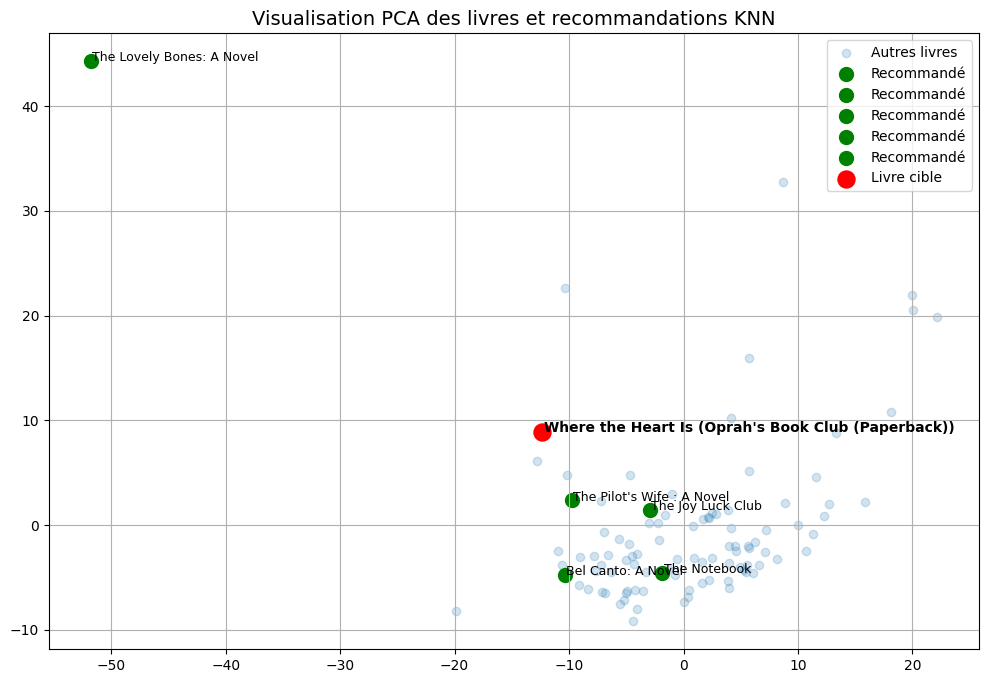

In [8]:
plot_recommendations("Where the Heart Is (Oprah's Book Club (Paperback))")